# SYSID - Atividade 02

Aluno: Pedro Henrique Cardoso Paulo

Professor: Helon Ayala

## Objetivo

O objetivo do código aqui mostrado é apresentaar alguns conceitos básicos do proceesso de ajuste por mínimos quadrados. Esse nb pode servir de base para outras atividades com as devidas adaptações.

## Passo 0 - Inicializando o Nb

### 0.1 - Limpando memória, prompt e inicializando random seed

In [1]:
% MEC 2015 System identification
% Prof Helon Ayala

clc
clear
close all
rng(1) % permite reproducibilidade (indisponivel no octave 6 que usei)
random_seed = 1;
randn("seed", random_seed);

error: 'rng' undefined near line 1, column 1

The 'rng' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.


### 0.2 - Importando pacotes

Parra esse caso, não serão necessários pacotes.

In [8]:
%pkg load control %pkg control: funcoes de transferencia e c2d

## Passo 1 - Carregando os dados

Para esse caso, serão usados dados reais de um braço robótico. Os dados podem ser baixados no seguinte endereço:

<a>https://ftp.esat.kuleuven.be/pub/SISTA/data/mechanical/robot_arm.dat.gz</a>

Os dados foram baixados compactados e extraídos, resultando em um arquivo de texto.

### 1.1 - Importando os dados

In [2]:
DATA = dlmread('data/robot_arm.dat');
Y = DATA(:,1);
U = DATA(:,2);

% vetor tempo discreto
t = (1:length(Y));

Espera-se que um ajuste por mínimos quadrados retorne um vetor $\theta$ similar ao descrito.

### 1.2 - Visualizando os dados

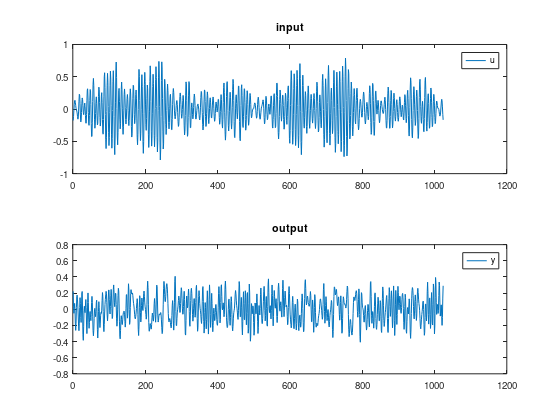

In [3]:
% plot training data
figure
subplot(2,1,1)
plot(t,U)
title('input')
legend('u');
subplot(2,1,2)
plot(t,Y)
title('output')
legend('y');

### 1.3 - Dividindo dados em treino e vaalidação

Para esse exercício, vamos propor uma divisão do trend em 50% de dados para o treino e 50% para a validação

In [4]:
train_fraction = 0.5; % Fracao de valores para treino
n = length(t);

n_TRA = round(n*train_fraction) % Numero de elementos para treino
n_VAL = n - n_TRA

tTRA = t(1:n_TRA);
tVAL = t(n_TRA+1:end);

YTRA = Y(1:n_TRA);
YVAL = Y(n_TRA+1:end);

UTRA = U(1:n_TRA);
UVAL = U(n_TRA+1:end);


n_TRA = 512
n_VAL = 512


## Parte 2 - Realizando ajuste

Nessa primeira etapa vamos tentar ajustar nosso problema com um modelo de ordem 2 e ver os resultados. Em etapa posterior, tentaremos variar a ordem apra identificar uma razoável.

### 2.1 - Definindo funções úteis

As funções necessárias já foram anteriormente implementadas no notebook `Codigo_exemplo.ipynb`. Para facilitar seu reaproveitamento, elas forma transferidas para arquivos `.m` no diretório deste notebook. As funções em questão são:

* `matReg` : função que gera a matriz de regressão. Salva em `matReg.m`
* `simulate_OSA`  : função para simulação de um passo a frente. Salva em `simulate_OSA.m`
* `simulate_FS` : função para simulação livre. Salva em `simulate_FS.m`

### 2.2 - Calculando matriz de regressão para ambos os trends

In [5]:
[Phi, Y1]    = matReg (YTRA, UTRA, 2, 2);
[PhiVAL, Y2] = matReg (YVAL, UVAL, 2, 2);

### 2.3 - Estimando os parâmetros

In [6]:
% estimate parameters:
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1 % batch least squares

th_hat =

  -1.3183e+00
   8.3163e-01
  -2.8600e-02
   9.8204e-04



## Parte 3 - Comparação dos resultados

### 3.1 - Realizando a simulação

In [7]:
% one step ahead prediction
yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, 2, 2);
yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, 2, 2);

[yhat_VAL_OSA yhat_VAL_FS];

### 3.2 - Comparando conjunto de treino

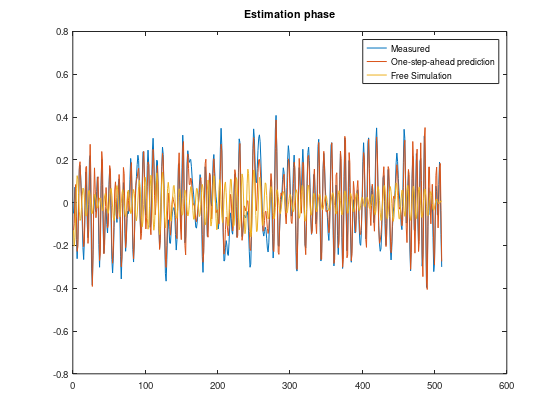

In [8]:
% plot predictions
figure
plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
title('Estimation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 3.3 - Comparando resultados da validação

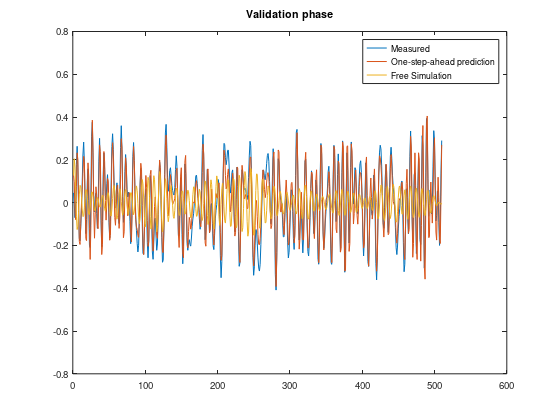

In [9]:
figure
plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
title('Validation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 3.4 - Conclusões da comparação

A comparação dos resultados nos leva a concluir que o modelo de segunda ordem representou de froma mediana os dados de ajuste e os de teste na simulação de um passo a frente. Já na simulação livre, nenhum dos dois modelos foi bem representado. Isso pode ser tomado como um indicativo que ordem 2, tal como usado no exemplo de código fornecido, é pouco para representar a física do problema

## Parte 4 - Verificando o impacto da ordem do modelo

Nesta seção vamos fazer alguns testes com diferentes ordens de modelos com o objetivo de definir qual a melhor para representar o nosso problema. Os modelos serão comparados visualmente e atrvés da métrica de erro quadrático médio, definida abaixo:

$\epsilon = \frac{1}{N}\sum_{i=1}^N (y_i - \hat{y}_i)^2$

### 4.1 - Selecionando possíveis valores de na e nb

In [10]:
n_rng = (1:6);         %range de n's a testar
nns   = length(n_rng); %numero de n's a testar

### 4.2 - Realizando simulações

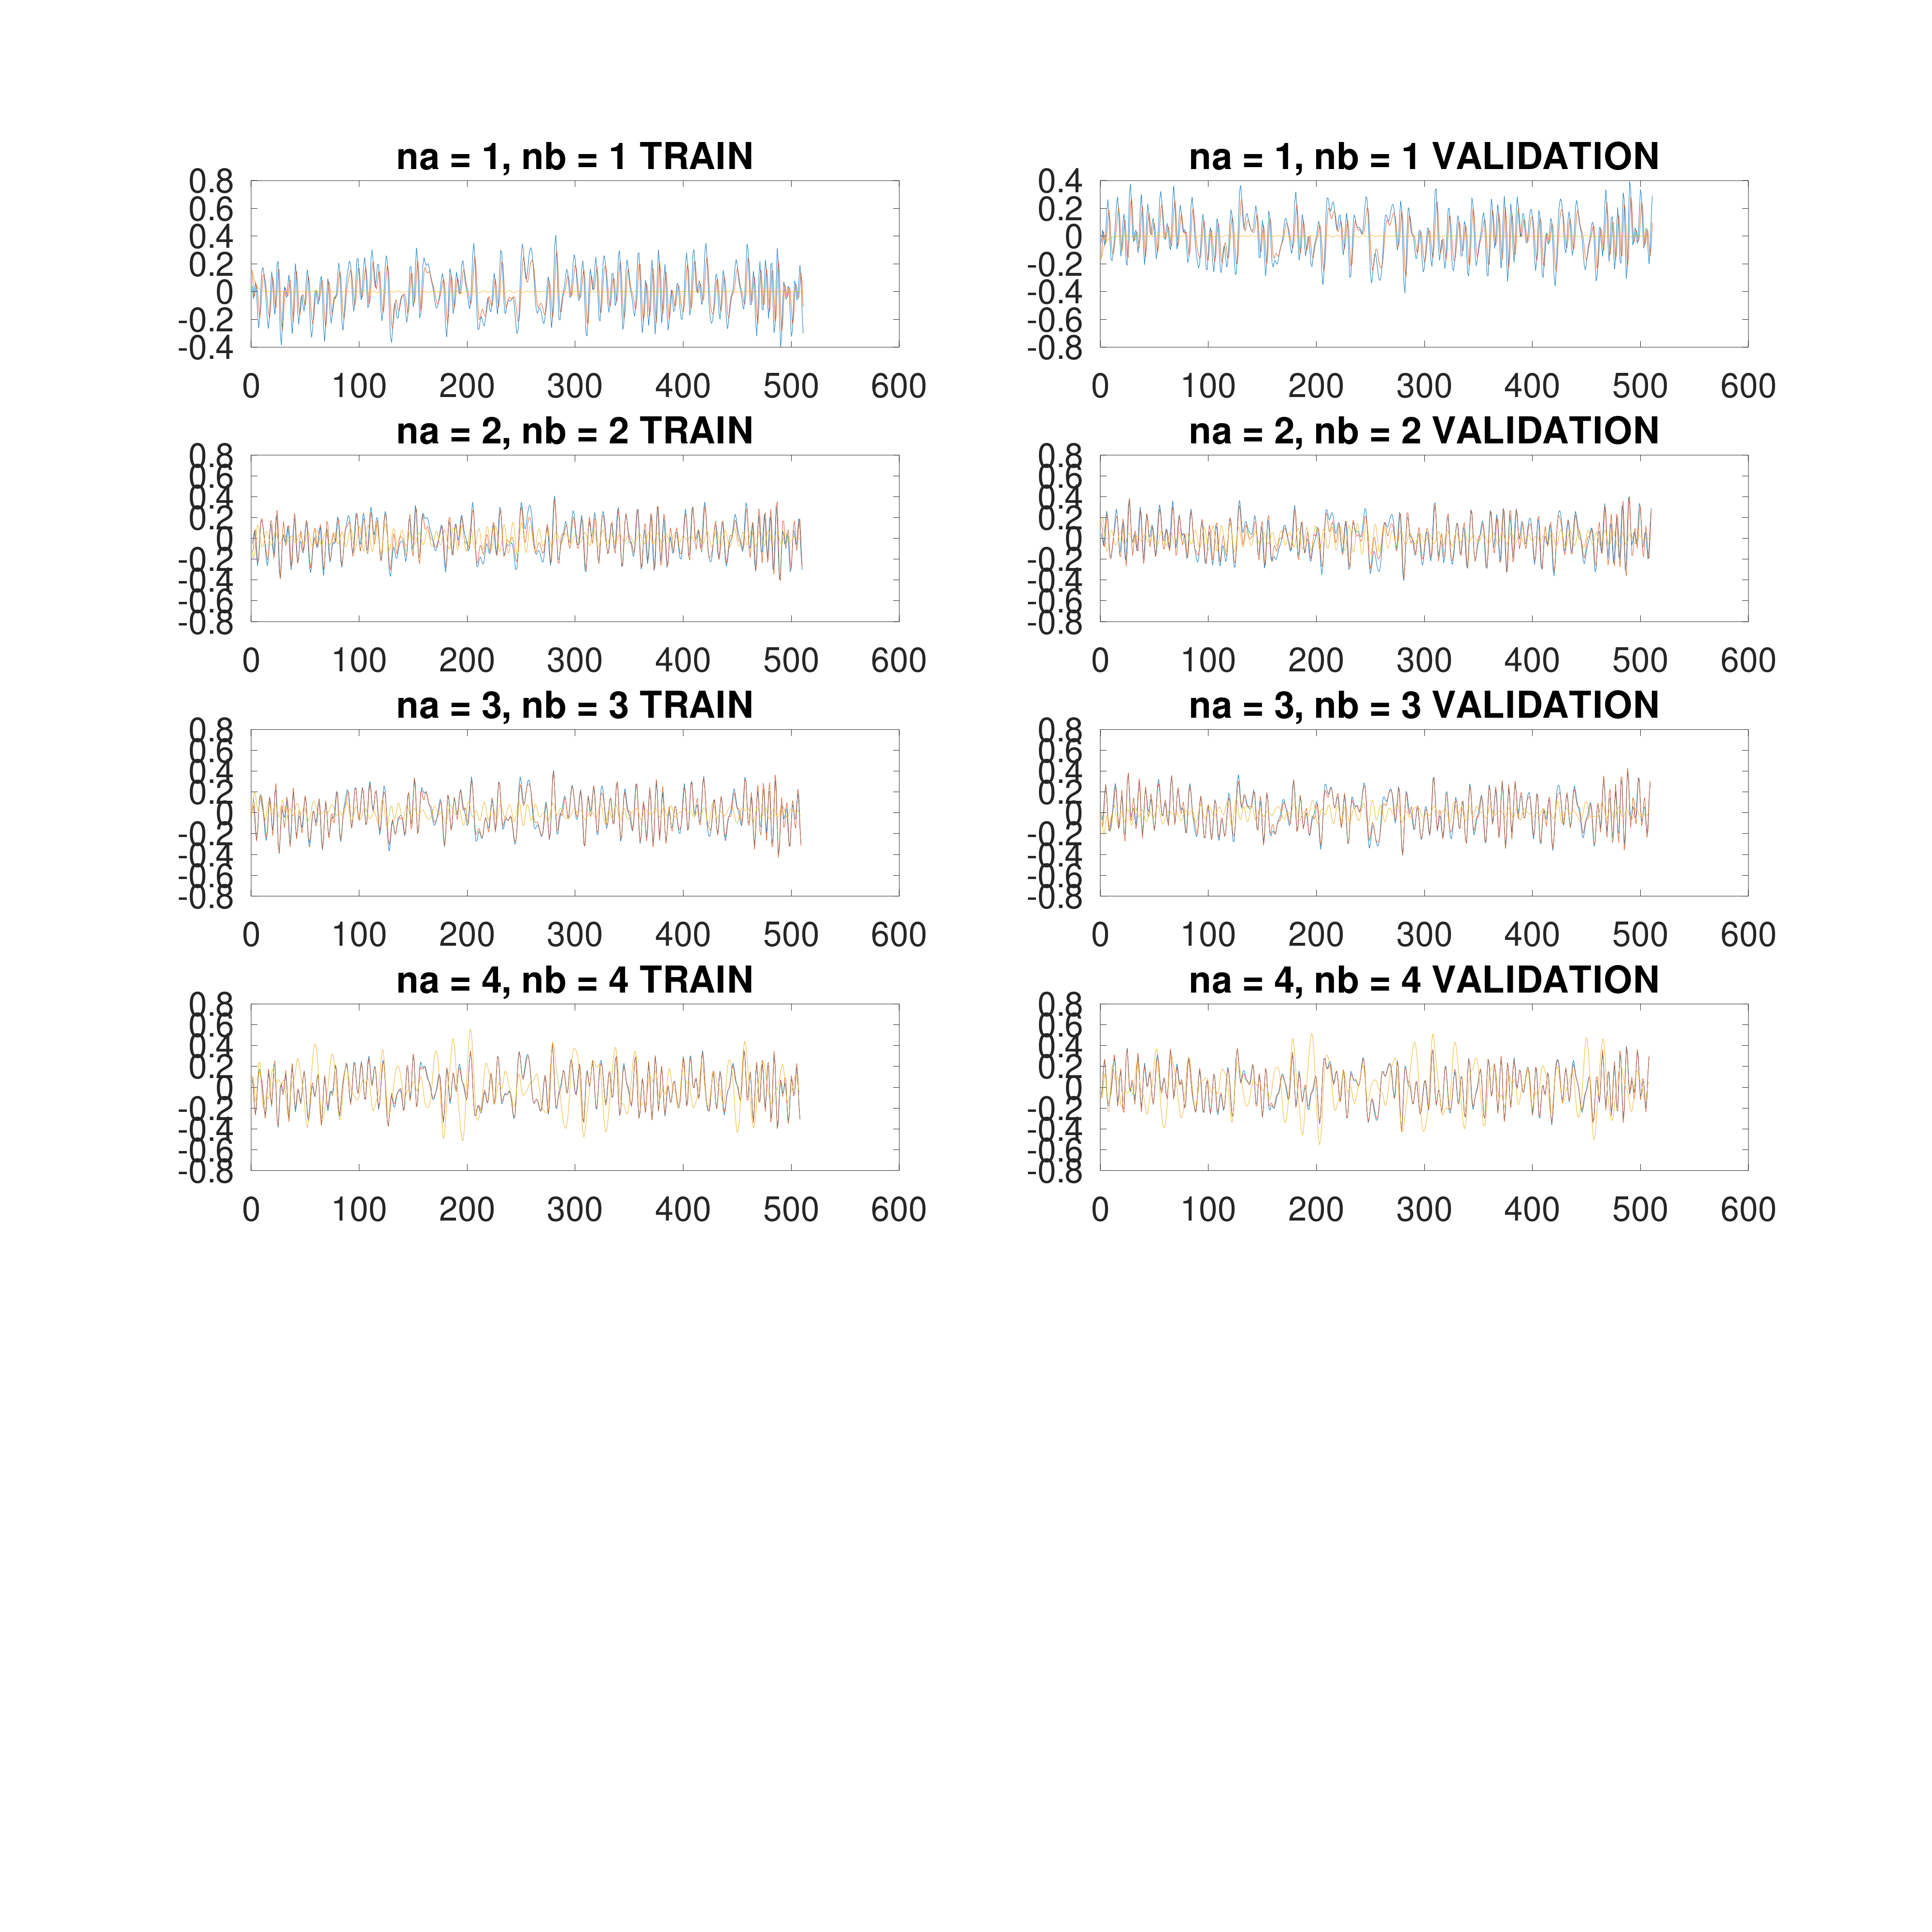

In [11]:
error_OSA = [];
error_FS = [];
figure("position", [300 200 4000 4000])
index = 1;
for i=1:nns
    na = n_rng(i);
    nb = n_rng(i);
    %Step 1 - Gerando matriz
    [Phi, Y1]    = matReg (YTRA, UTRA, na, nb);
    [PhiVAL, Y2] = matReg (YVAL, UVAL, na, nb);

    %Step 2 - Resolvendo sistema
    th_hat = (Phi'*Phi)^(-1)*Phi'*Y1;

    %Step 3 - Simulando
    yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
    yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

    yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, na, nb);
    yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, na, nb);

    %% Erro da simulacao
    error_OSA = [error_OSA; [na nb mean((Y1 .- yhat_TRA_OSA).^2) mean((Y2 .- yhat_VAL_OSA).^2)]];
    error_FS = [error_FS; [na nb mean((Y1 .- yhat_TRA_FS).^2) mean((Y2 .- yhat_VAL_FS).^2)]];

    %Step 4 - Plotando
    subplot(nns,2,index)
    plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' TRAIN'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;
    

    subplot(nns,2,index)
    plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' VALIDATION'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;

endfor

Erros calculados:

In [12]:
error_OSA

error_OSA =

   1.0000e+00   1.0000e+00   1.2973e-02   1.2856e-02
   2.0000e+00   2.0000e+00   4.0948e-03   4.1089e-03
   3.0000e+00   3.0000e+00   1.3201e-03   1.3372e-03
   4.0000e+00   4.0000e+00   3.9451e-04   3.9770e-04
   5.0000e+00   5.0000e+00   1.0108e-04   1.1431e-04
   6.0000e+00   6.0000e+00   1.5530e-05   1.5802e-05



In [13]:
error_FS

error_FS =

    1.0000e+00    1.0000e+00    2.7227e-02    2.7044e-02
    2.0000e+00    2.0000e+00    2.9168e-02    2.8873e-02
    3.0000e+00    3.0000e+00    2.6410e-02    2.6147e-02
    4.0000e+00    4.0000e+00    4.6010e-02    4.7432e-02
    5.0000e+00    5.0000e+00   1.6343e+285   5.8867e+285
    6.0000e+00    6.0000e+00           Inf           Inf



Plotando os erros (cortando valores acima de 5):

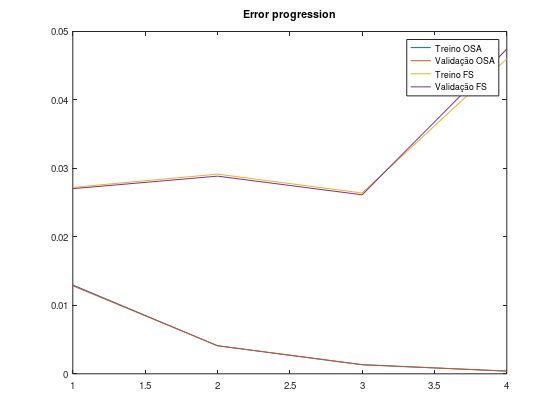

In [14]:
figure
plot(error_OSA(1:end-2,1), [error_OSA(1:end-2,3:end) error_FS(1:end-2,3:end)])
title(['Error progression'])
legend('Treino OSA','Validação OSA', 'Treino FS','Validação FS')

É possível notar que para casos de `na = nb >= 5` o modelo divergiu para a simulação livre, não gerando resultados. Por essa comparação o melhor resultado tenderia a ser `na = nb = 3` considerando o menor erro na FS. Vamos agora tentar tunar os parâmetros com base em `na` e `nb` individualmente.

### 4.3 - Ajustando melhor `na` e `nb`:

Nessa caso, vamos usar `na` como parâmetro de ajuste e tentar selecionar o melhor valor com base numa sensibilidade em `nb`. O resultado atingiddo foi um `na = 2`, acima do qual temos o risco de divergência para bbalores altos de `nb`.

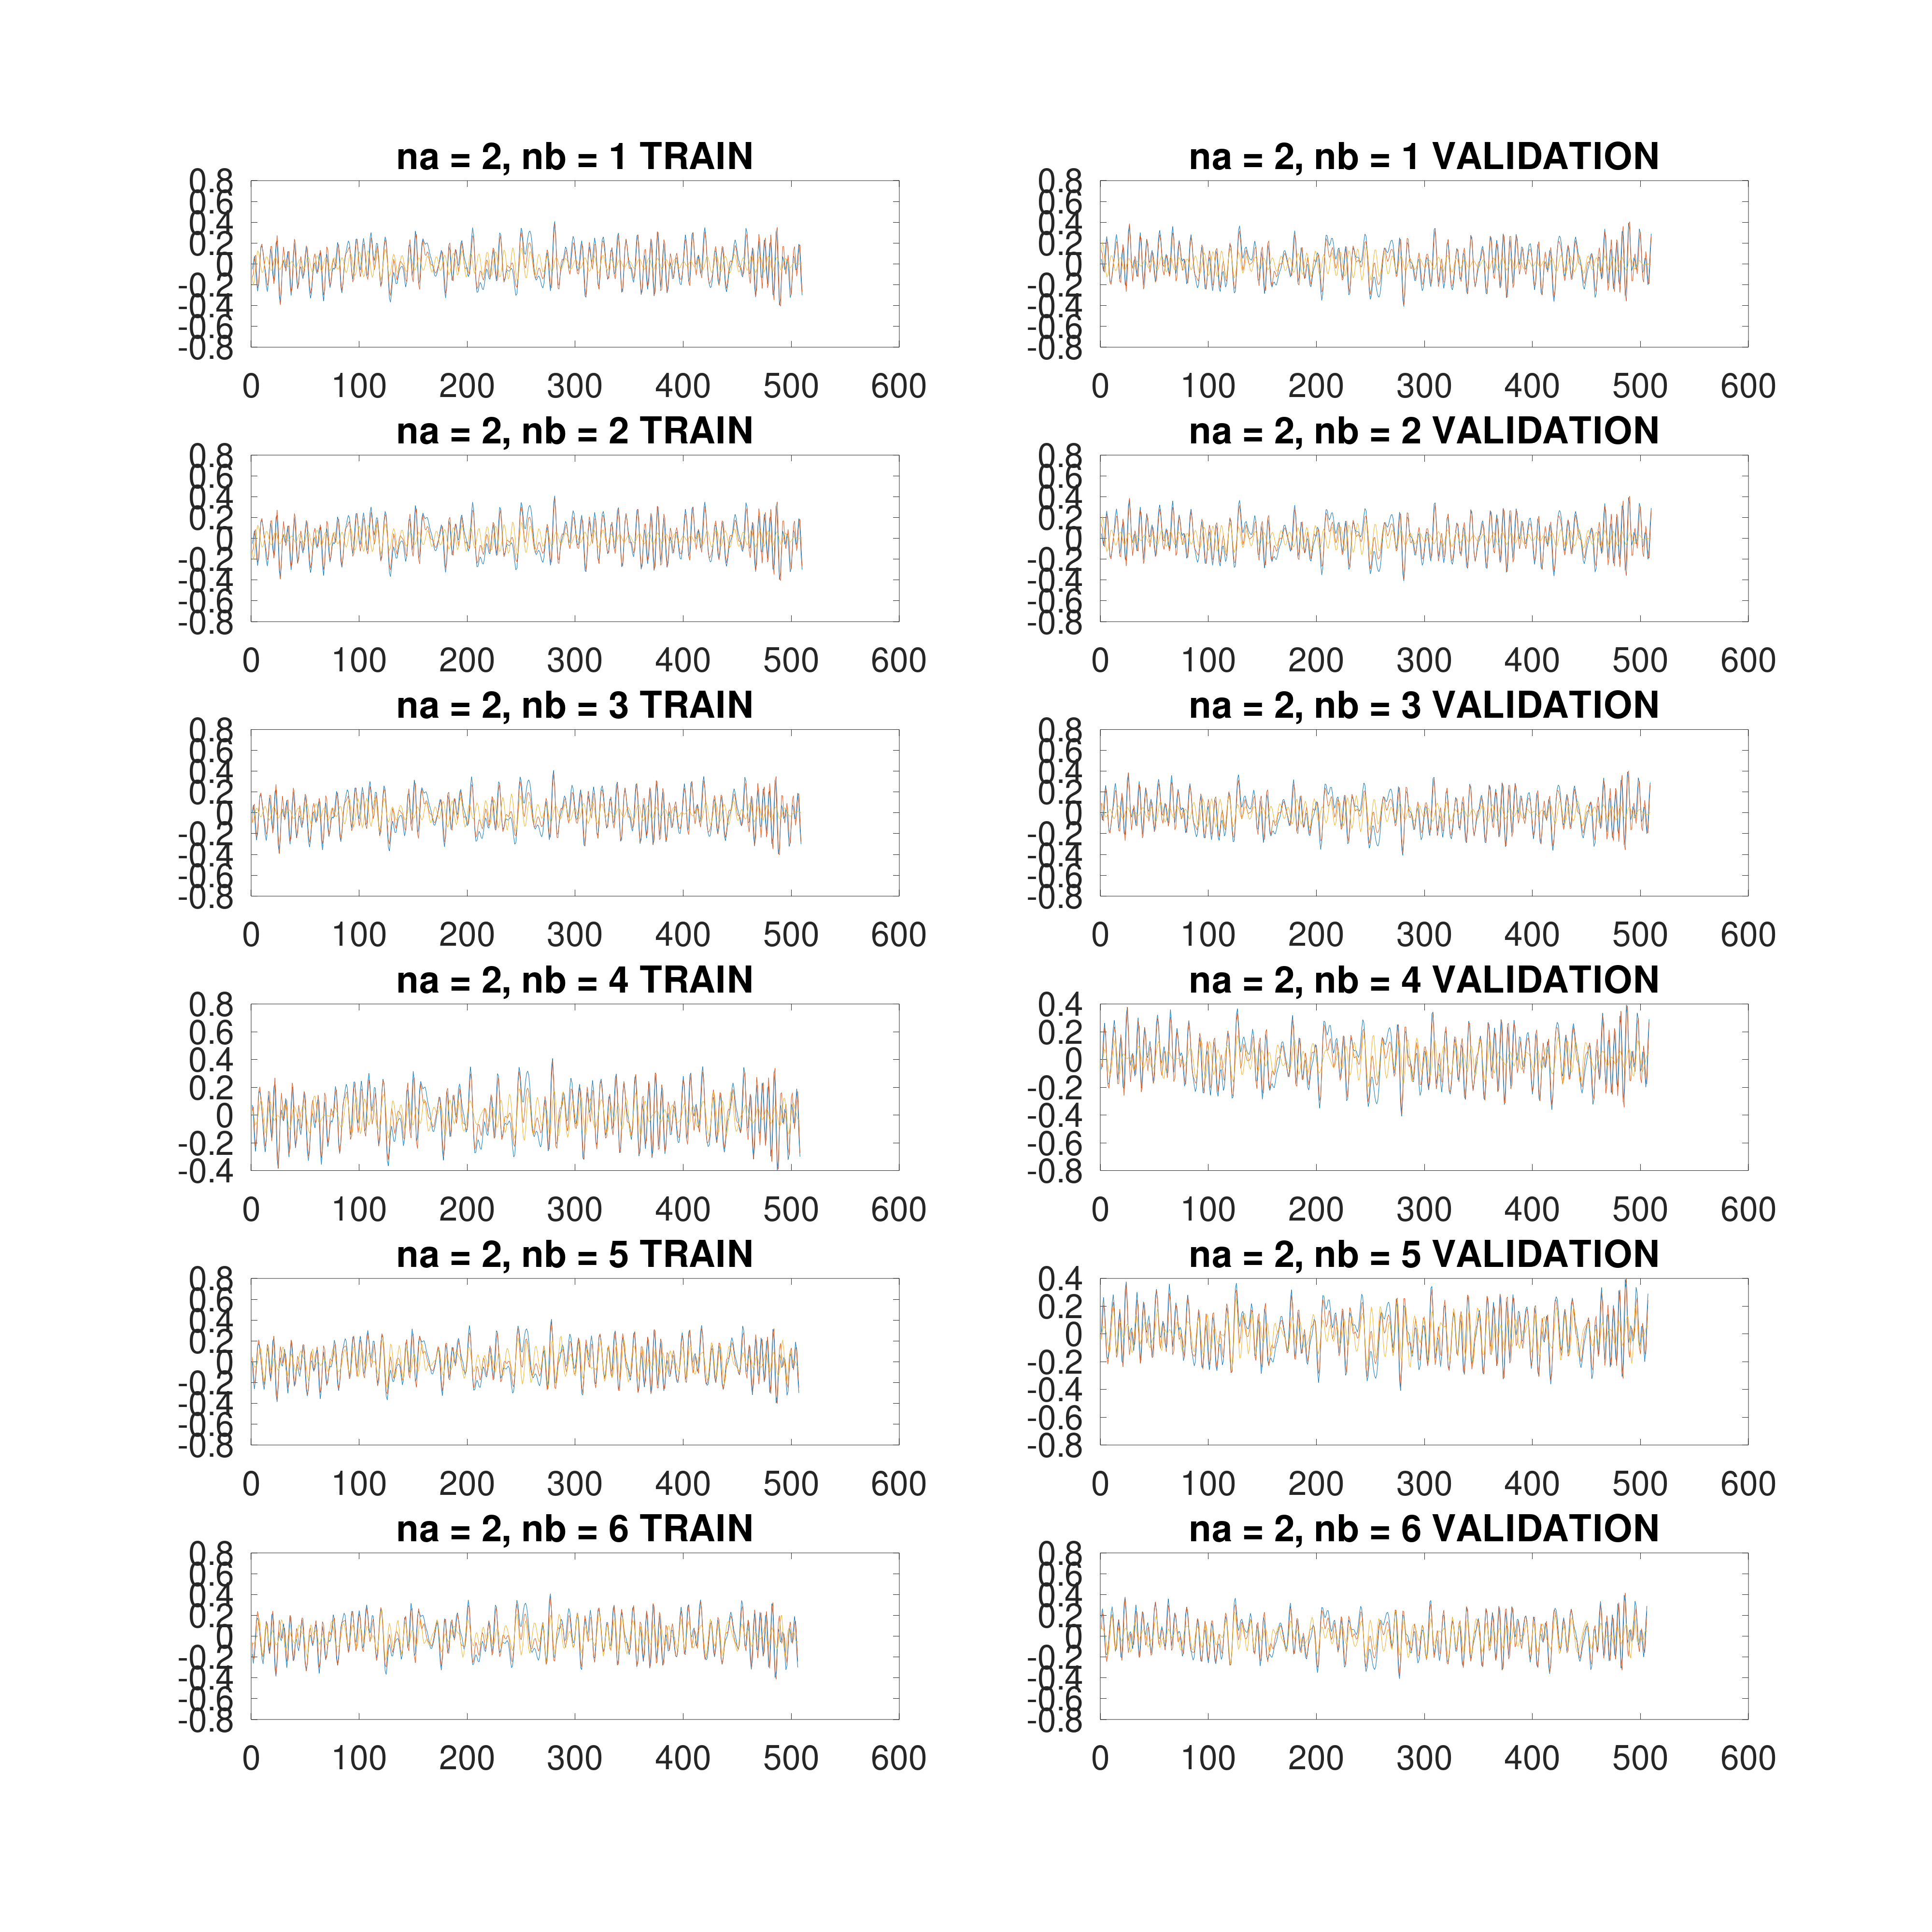

In [15]:
error_OSA = [];
error_FS = [];
n_rng = (1:6);
nns = length(n_rng);
figure("position", [300 200 4000 4000])
index = 1;
for i=1:nns
    na = 2; %aqui ajustamos
    nb = n_rng(i);
    %Step 1 - Gerando matriz
    [Phi, Y1]    = matReg (YTRA, UTRA, na, nb);
    [PhiVAL, Y2] = matReg (YVAL, UVAL, na, nb);

    %Step 2 - Resolvendo sistema
    th_hat = (Phi'*Phi)^(-1)*Phi'*Y1;

    %Step 3 - Simulando
    yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
    yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

    yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, na, nb);
    yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, na, nb);

    error_OSA = [error_OSA; [na nb mean((Y1 .- yhat_TRA_OSA).^2) mean((Y2 .- yhat_VAL_OSA).^2)]];
    error_FS = [error_FS; [na nb mean((Y1 .- yhat_TRA_FS).^2) mean((Y2 .- yhat_VAL_FS).^2)]];

    %Step 4 - Plotando
    subplot(nns,2,index)
    plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' TRAIN'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;
    

    subplot(nns,2,index)
    plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' VALIDATION'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;

endfor

Erros calculados:

In [16]:
error_OSA

error_OSA =

   2.0000e+00   1.0000e+00   4.0948e-03   4.1090e-03
   2.0000e+00   2.0000e+00   4.0948e-03   4.1089e-03
   2.0000e+00   3.0000e+00   4.0782e-03   4.0930e-03
   2.0000e+00   4.0000e+00   3.9430e-03   3.9386e-03
   2.0000e+00   5.0000e+00   3.6916e-03   3.6786e-03
   2.0000e+00   6.0000e+00   3.5598e-03   3.5811e-03



In [17]:
error_FS

error_FS =

   2.000000   1.000000   0.029203   0.028910
   2.000000   2.000000   0.029168   0.028873
   2.000000   3.000000   0.029373   0.029015
   2.000000   4.000000   0.025050   0.024646
   2.000000   5.000000   0.019515   0.019219
   2.000000   6.000000   0.016594   0.016486



A conclusão que temos com a inspeção visual do gráfico é que `na = 2` é o valor mais adequado ao problema considerando valores de OSA e FS. Para essa premissa, os valores de `nb` parecem melhorar o resultado conforme crescem. Agora, vamos vallidar a conclusão fazendo a sensibilidade em `na`: 

nns = 6


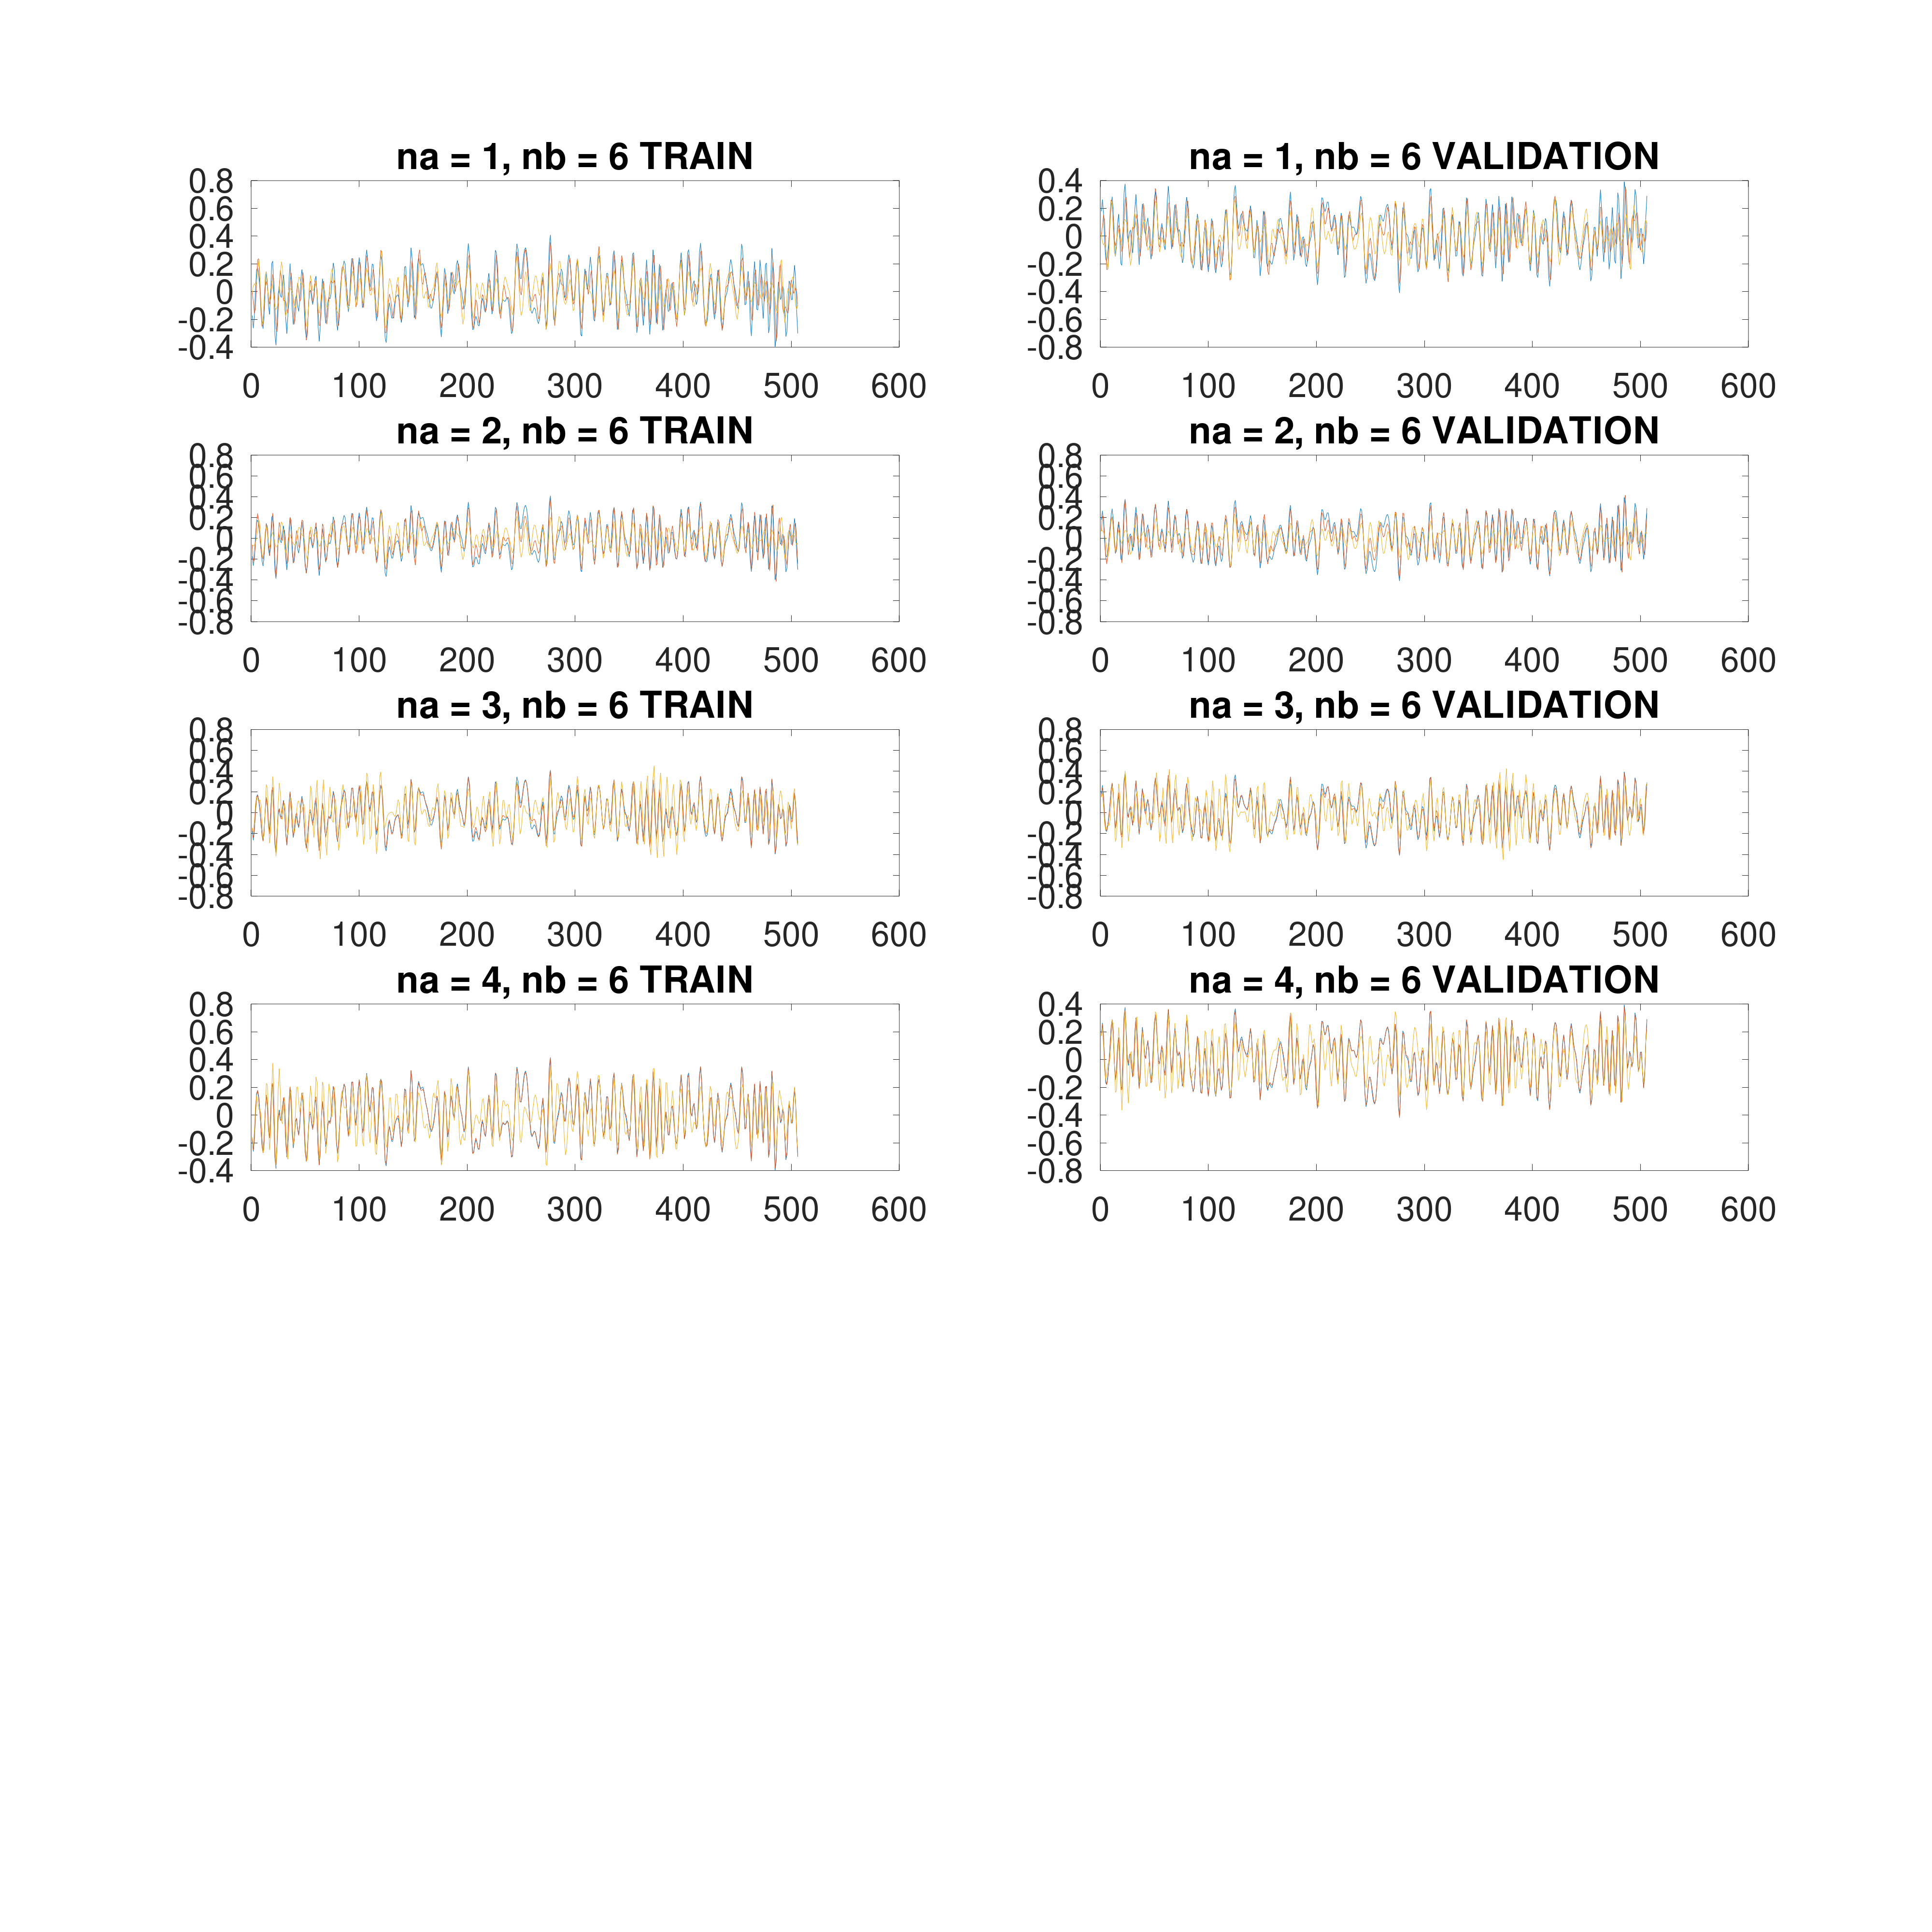

In [18]:
error_OSA = [];
error_FS = [];
n_rng = (1:6);
nns = length(n_rng)
figure("position", [300 200 4000 4000])
index = 1;
for i=1:nns
    na = n_rng(i); %aqui ajustamos
    nb = 6;
    %Step 1 - Gerando matriz
    [Phi, Y1]    = matReg (YTRA, UTRA, na, nb);
    [PhiVAL, Y2] = matReg (YVAL, UVAL, na, nb);

    %Step 2 - Resolvendo sistema
    th_hat = (Phi'*Phi)^(-1)*Phi'*Y1;

    %Step 3 - Simulando
    yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
    yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

    yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, na, nb);
    yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, na, nb);

    error_OSA = [error_OSA; [na nb mean((Y1 .- yhat_TRA_OSA).^2) mean((Y2 .- yhat_VAL_OSA).^2)]];
    error_FS = [error_FS; [na nb mean((Y1 .- yhat_TRA_FS).^2) mean((Y2 .- yhat_VAL_FS).^2)]];

    %Step 4 - Plotando
    subplot(nns,2,index)
    plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' TRAIN'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;
    

    subplot(nns,2,index)
    plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
    title(['na = ' int2str(na) ', nb = ' int2str(nb) ' VALIDATION'])
    %legend('Measured','One-step-ahead prediction', 'Free Simulation')
    index = index + 1;

endfor

Verificando os valores de erro:

In [19]:
error_OSA

error_OSA =

   1.0000e+00   6.0000e+00   7.2697e-03   7.3543e-03
   2.0000e+00   6.0000e+00   3.5598e-03   3.5811e-03
   3.0000e+00   6.0000e+00   4.5939e-04   4.5975e-04
   4.0000e+00   6.0000e+00   9.0726e-05   8.2232e-05
   5.0000e+00   6.0000e+00   1.8443e-05   1.6060e-05
   6.0000e+00   6.0000e+00   1.5530e-05   1.5802e-05



In [20]:
error_FS

error_FS =

   1.000000   6.000000   0.014115   0.014223
   2.000000   6.000000   0.016594   0.016486
   3.000000   6.000000   0.018963   0.018041
   4.000000   6.000000   0.014572   0.014047
   5.000000   6.000000        Inf        Inf
   6.000000   6.000000        Inf        Inf



Os testes feitos corroboraram a conclusão anterior, com o adendo de demonstrar que, para `na = 1` temos o aparente ponto de mínimo do erro da simulação livre. Manteremos `na = 2` como nosso caso base pensando no resultado da simulação OSA.

### 4.4 - Gerando resultados do novo caso base

In [21]:
na = 2;
nb = 6;

%Step 1 - Gerando matriz
[Phi, Y1]    = matReg (YTRA, UTRA, na, nb);
[PhiVAL, Y2] = matReg (YVAL, UVAL, na, nb);

%Step 2 - Resolvendo sistema
th_hat = (Phi'*Phi)^(-1)*Phi'*Y1;

%Step 3 - Simulando
yhat_TRA_OSA = simulate_OSA (Phi, th_hat);
yhat_VAL_OSA = simulate_OSA (PhiVAL, th_hat);

yhat_TRA_FS = simulate_FS (Phi(1,:), th_hat, UTRA, na, nb);
yhat_VAL_FS = simulate_FS (PhiVAL(1,:), th_hat, UVAL, na, nb);

### 4.5 - Comparando resultados de treino (nova validação)

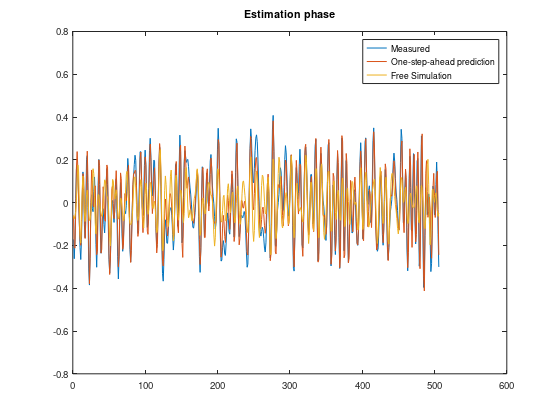

In [22]:
% plot predictions
figure
plot([Y1 yhat_TRA_OSA yhat_TRA_FS])
title('Estimation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

### 4.6 - Comparando os resultados de validação (novo treino)

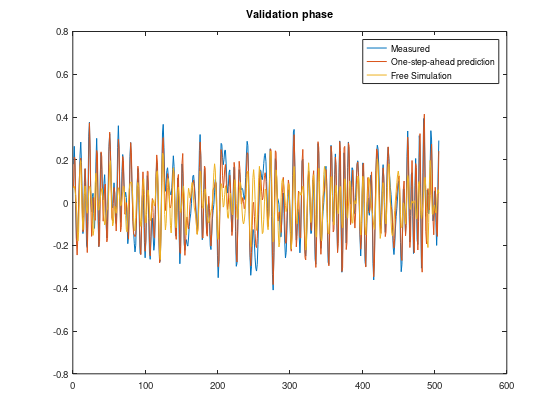

In [23]:
figure
plot([Y2 yhat_VAL_OSA yhat_VAL_FS])
title('Validation phase')
legend('Measured','One-step-ahead prediction', 'Free Simulation')

# Parte 5 - Conclusões

* O modelo encontrado é bom, porém cabe melhorias
* Valores altos de `na` temdem a causar instabilidade
* valores altos de `nb`, se não associados a valores altos de `na`, tendem a melhorar o resultado
* A melhor ordem de modelo seria `na = nb = 3` ou `na = 2` e `nb = 6`